In [1]:
%matplotlib inline
import json
import tabulate
import datetime
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

def int2dur(x):
    minutes = int(x // 60)
    seconds = int(round(x - minutes * 60))
    return f"{minutes: 3d}m{seconds:02d}s"

class CPDF_Point:
    """
    spread out the cdf-ness. Starts at `point-spread/2` and ends at `point+spread/2`
    """
    def __init__(self, point, spread):
        self.point = point
        self.spread = spread
        self.lo = point - spread / 2.0
        self.hi = point + spread / 2.0
        self.type = "COSINE"
    
    def cdf(self, x):
        frac = (x - self.lo) / self.spread
        if x < self.lo:
            return 0.0
        elif x > self.hi:
            return 1.0
        elif self.type == "LINEAR":
            return frac
        elif self.type == "COSINE":
            # f(x) = (1-cos( frac * pi )) / 2.0
            return (1 - np.cos( frac * np.pi)) / 2.0
    
    def pdf(self, x):

        if x < self.lo:
            return 0.0
        elif x > self.hi:
            return 0.0
        elif self.type == "LINEAR":
            return 1.0 / self.spread
        elif self.type == "COSINE":
            return np.pi * np.sin(np.pi * (self.lo - x) / (self.lo - self.hi))/ (2 * (self.hi - self.lo))
        
        
class CPDF:
    def __init__(self, points, spread):
        self.points = [CPDF_Point(_, spread) for _ in points]

    def eval_cdf_at(self, x):
        scale = len(self.points)
        return sum(_.cdf(x) for _ in self.points) / scale
        
    def eval_pdf_at(self, x):
        scale = len(self.points)
        return sum(_.pdf(x) for _ in self.points) / scale


def make_cdf(x):
    cdf_x = [0.0]
    cdf_y = [0.0]
    for idx, val in enumerate(x):
        cdf_x.append(val / 60.0)
        cdf_y.append(cdf_y[-1])
        
        cdf_x.append(val / 60.0)
        cdf_y.append((1 + idx) / len(x))
    return [cdf_x, cdf_y]

def analyze_speakers(data, title="", _filter=None):

    if _filter is not None:
        new_data = [_ for _ in data if _filter(_)]
    else:
        new_data = [_ for _ in data]
    speakers = [_ for sublist in new_data for _ in sublist["speakers"]]
    
    if title != "":
        print(f"\n=====[ Analyzing '{title}' ]=====\n")

        
    N_first_female = sum([1 for _ in new_data if _["speakers"][0]["sex"] == "female"])
    N_first_male = sum([1 for _ in new_data if _["speakers"][0]["sex"] == "male"])

    N_last_female = sum([1 for _ in new_data if _["speakers"][-1]["sex"] == "female"])
    N_last_male = sum([1 for _ in new_data if _["speakers"][-1]["sex"] == "male"])
    
    
    sex = [_["sex"] for _ in speakers]
    duration = [_["duration"] for _ in speakers]

    total_duration = sum(duration)
    female_durations = list(sorted([_["duration"] for _ in speakers if _["sex"] == "female"]))
    male_durations = list(sorted([_["duration"] for _ in speakers if _["sex"] == "male"]))
    
    table = {
        "sex": ["female", "male"],
        "N": [len(female_durations), len(male_durations)],
        "N first": [N_first_female, N_first_male],
        "N last": [N_last_female, N_last_male],
        "total": [int2dur(sum(female_durations)), int2dur(sum(male_durations))],
        "percent": [sum(female_durations)/total_duration*100, sum(male_durations)/total_duration*100],
        "min": [int2dur(min(female_durations)), int2dur(min(male_durations))],
        "mean": [int2dur(np.mean(female_durations)), int2dur(np.mean(male_durations))],
        "max": [int2dur(max(female_durations)), int2dur(max(male_durations))],
    }
    
    print(tabulate.tabulate(table, headers="keys"))
    
    k = len(female_durations)
    n = len(speakers)
    alpha = 0.05  # 95% confidence
    p_u, p_o = beta.ppf([alpha/2, 1 - alpha/2], [k, k + 1], [n - k + 1, n-k])
    print(f"The observed rate of females speaking is {k / n * 100:.2f}%")
    print(f"I am 95% confident that the true rate is between {p_u*100:.2f}% and {p_o * 100:.2f}%")
    #print("female stats", p_u, k / n, p_o)
    
    cpdf_female = CPDF(female_durations, 60.0)
    cpdf_male = CPDF(male_durations, 60.0)
    x = np.linspace(0.0, 30.0 * 60.0, 500)
    x_minutes = [_ / 60.0 for _ in x]
    cdf_female = [cpdf_female.eval_cdf_at(_) for _ in x]
    cdf_male = [cpdf_male.eval_cdf_at(_) for _ in x]
    pdf_female = [cpdf_female.eval_pdf_at(_) for _ in x]
    pdf_male = [cpdf_male.eval_pdf_at(_) for _ in x]
    
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle(title)
    ax1.plot(x_minutes, cdf_female, c="m", label="female")
    ax1.plot(x_minutes, cdf_male, c="c", label="male")

    ax2.plot(x_minutes, pdf_female, c="m")
    ax2.plot(x_minutes, pdf_male, c="c")
    
    fig.legend()
    #fig.show()

In [2]:
with open("data_no_duration.json", "r") as stream:
    data = json.load(stream)
    
print(f"Found {len(data)} meetings")
meeting_types = set([_["meeting"] for _ in data])
meeting_types

Found 24 meetings


{'regular'}


=====[ All Speakers ]=====

sex       N  95% CI lo    rate    95% CI hi
------  ---  -----------  ------  -----------
female   27  35.35%       49.09%  62.93%
male     28  37.07%       50.91%  64.65%

=====[ First Speakers ]=====

sex       N first  95% CI lo    rate    95% CI hi
------  ---------  -----------  ------  -----------
female         16  44.68%       66.67%  84.37%
male            8  15.63%       33.33%  55.32%

=====[ Last Speakers ]=====

sex       N last  95% CI lo    rate    95% CI hi
------  --------  -----------  ------  -----------
female         8  15.63%       33.33%  55.32%
male          16  44.68%       66.67%  84.37%


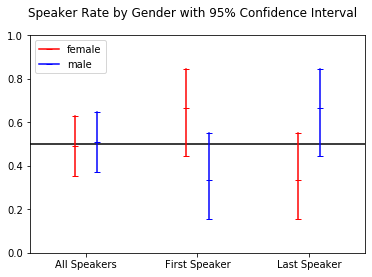

In [3]:
ci = 0.95  # 2 sigma
ci_label = f"{ci*100:.0f}%"

#ci = 0.68  # 1 sigma
#ci_label = "1-sigma"


def bounds(k, n):
    # k = events
    # n = total events
    alpha = 1.0 - ci
    p_u, p_o = beta.ppf([alpha/2, 1 - alpha/2], [k, k + 1], [n - k + 1, n-k])
    return p_u, p_o
    
def analyze_speakers(data, title=""):

    meetings = [_["speakers"] for _ in data]
    N_meetings = len(meetings)
    
    speakers = []
    for meeting in meetings:
        speakers = speakers + meeting
        
    if title != "":
        print(f"\n=====[ Analyzing '{title}' ]=====\n")

    assert set(speakers) == set(["female", "male"])
        
    N_speakers = len(speakers)
    N_first_female = sum([1 for _ in meetings if _[0] == "female"])
    N_first_male = sum([1 for _ in meetings if _[0] == "male"])
    assert N_meetings == N_first_female + N_first_male
    
    N_last_female = sum([1 for _ in meetings if _[-1] == "female"])
    N_last_male = sum([1 for _ in meetings if _[-1] == "male"])
    assert N_meetings == N_last_female + N_last_male
  
    N_female = speakers.count("female")
    N_male = speakers.count("male")

    rate_female = N_female / N_speakers
    rate_male = N_male / N_speakers
    
    
    rate_female_lo, rate_female_hi = bounds(N_female, N_speakers)
    rate_male_lo, rate_male_hi = bounds(N_male, N_speakers)
    
    rate_first_female_lo, rate_first_female_hi = bounds(N_first_female, N_meetings)
    rate_first_male_lo, rate_first_male_hi = bounds(N_first_male, N_meetings)
    
    rate_last_female_lo, rate_last_female_hi = bounds(N_last_female, N_meetings)
    rate_last_male_lo, rate_last_male_hi = bounds(N_last_male, N_meetings)
    
    print("\n=====[ All Speakers ]=====\n")
    table = {
        "sex": ["female", "male"],
        "N": [N_female, N_male],
        #"N first": [N_first_female, N_first_male],
        #"N last": [N_last_female, N_last_male],
        f"{ci_label} CI lo": [f"{rate_female_lo*100:.2f}%", f"{rate_male_lo*100:.2f}%"],
        "rate": [f"{rate_female * 100:.2f}%", f"{rate_male*100:.2f}%"],
        f"{ci_label} CI hi": [f"{rate_female_hi*100:.2f}%", f"{rate_male_hi*100:.2f}%"],
    }
    print(tabulate.tabulate(table, headers="keys"))
    
    print("\n=====[ First Speakers ]=====\n")
    table = {
        "sex": ["female", "male"],
        "N first": [N_first_female, N_first_male],
        f"{ci_label} CI lo": [f"{rate_first_female_lo*100:.2f}%", f"{rate_first_male_lo*100:.2f}%"],
        "rate": [f"{N_first_female / N_meetings * 100:.2f}%", f"{N_first_male / N_meetings*100:.2f}%"],
        f"{ci_label} CI hi": [f"{rate_first_female_hi*100:.2f}%", f"{rate_first_male_hi*100:.2f}%"],
    }
    print(tabulate.tabulate(table, headers="keys"))
    
    print("\n=====[ Last Speakers ]=====\n")
    table = {
        "sex": ["female", "male"],
        "N last": [N_last_female, N_last_male],
        f"{ci_label} CI lo": [f"{rate_last_female_lo*100:.2f}%", f"{rate_last_male_lo*100:.2f}%"],
        "rate": [f"{N_last_female / N_meetings * 100:.2f}%", f"{N_last_male / N_meetings*100:.2f}%"],
        f"{ci_label} CI hi": [f"{rate_last_female_hi*100:.2f}%", f"{rate_last_male_hi*100:.2f}%"],
    }
    print(tabulate.tabulate(table, headers="keys"))
    
    c_female = "red"
    c_male = "blue"
    
    fig, ax = plt.subplots()
    
    plt.plot([-100, 100], [0.5, 0.5], c="black")
    
    
    plt.plot(0*np.ones(3)-0.1, [rate_female_lo, rate_female, rate_female_hi], c=c_female, marker="_", label="female")
    plt.plot(0*np.ones(3)+0.1, [rate_male_lo, rate_male, rate_male_hi], c=c_male, marker="_", label="male")
    
    plt.plot(1*np.ones(3)-0.1, [rate_first_female_lo, N_first_female / N_meetings, rate_first_female_hi], c=c_female, marker="_")
    plt.plot(1*np.ones(3)+0.1, [rate_first_male_lo, N_first_male / N_meetings, rate_first_male_hi], c=c_male, marker="_")

    plt.plot(2*np.ones(3)-0.1, [rate_last_female_lo, N_last_female / N_meetings, rate_last_female_hi], c=c_female, marker="_")
    plt.plot(2*np.ones(3)+0.1, [rate_last_male_lo, N_last_male / N_meetings, rate_last_male_hi], c=c_male, marker="_")

    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['All Speakers', 'First Speaker', 'Last Speaker'])
    
    
    plt.suptitle(f"Speaker Rate by Gender with {ci_label} Confidence Interval")
    plt.xlim(-0.5, 2.5)
    plt.ylim(0, 1)
    plt.legend()
    plt.show()
    
    
    
    
analyze_speakers(data)